Data Source: https://www.kaggle.com/code/iabhishekofficial/prediction-on-hospital-readmission


Scaling Machine Learning with Distributed Computing: Developing and Deploying a Model on a Large Dataset using Hadoop or Spark

Problem Statement:

Hospital readmission in diabetic patients​

Centers for Medicare & Medicaid Services established the Hospital Readmissions Reduction Program to improve quality of care for patients and reduce healthcare spending by applying payment penalties to hospitals that have more than expected readmission rates for certain conditions.​

Being able to determine factors that lead to higher readmission in diabetic patients can help hospitals save millions of dollars while improving quality of care.​

Develop a machine learning model that can predict hospital readmissions in diabetic patients. Hospital readmissions are considered an indicator of hospital quality and affect the cost of care adversely.

Solution Approach:

Prepare Data  -->  Build ML Model --> Train & Test Model --> Manage Model --> Build Image with model & Dependencies --> Deploy on GCP --> Monitor the Model

Data Modeling Steps:

1. Data cleaning: This step involves identifying and removing or imputing invalid or missing values in the dataset. PySpark's DataFrame API provides several built-in functions to perform these tasks efficiently, such as dropna() to remove rows with missing values, and fillna() to fill missing values with a specific value or a statistical measure like mean or median.​

2. Data Visualization: To understand the data distribution for each feature, we visualized the data using boxplots. This helped us understand the dispersion of the data around the mean. Using matplotlib library and using plt.boxplot() we create boxplots of all the features.​

3. Feature selection: In this step, a subset of relevant features is selected for the analysis to improve the model's accuracy and efficiency. PySpark's DataFrame API offers several methods for feature selection, including select(), drop(), and filter(), which allow you to select specific columns, drop unwanted columns, and filter rows based on certain conditions.​

4. Feature engineering: Feature engineering involves creating new features based on domain knowledge and feature interactions to better capture the underlying patterns in the data. PySpark's DataFrame API provides several built-in functions for feature engineering, such as withColumn() to create new columns based on existing ones, and split() to split strings into multiple columns.​

5. Encoding categorical variables: Categorical variables need to be converted to numerical format for machine learning models to process them. One-hot encoding is a common method for encoding categorical variables, and PySpark's DataFrame API provides a OneHotEncoder class to perform this task efficiently.​

6. Balancing the dataset: Imbalanced datasets can lead to biased models, where the model is biased towards the majority class. To address this issue, the dataset can be balanced using techniques like under-sampling or over-sampling. PySpark's DataFrame API provides several methods for balancing datasets, such as sample() to randomly sample rows, and union() to combine multiple datasets.​

7. plitting the dataset: Finally, the dataset is split into training and testing sets for model evaluation. PySpark's DataFrame API provides a randomSplit() function to split the dataset into two or more subsets randomly based on the specified weights.​

8. Logistic regression is a binary classification algorithm that uses a logistic function to estimate the probability of the dependent variable (hospital readmission) based on the independent variables (patient characteristics). ​

9. Hyperparameter tuning – Accuracy metric to evaluate the performance of the trained model.​

Deployment on GCP can be seen in the word file attached 

In [ ]:
%%capture
!pip install pyspark
!pip install scikit-learn

In [ ]:
%%time
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
import matplotlib.pyplot as plt
import IPython
import pandas as pd,numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

CPU times: user 415 µs, sys: 0 ns, total: 415 µs
Wall time: 1.16 ms


**Mounted colab to our project drive to access the data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Create Sparksession and Read the data . SparkSession is the entry point to PySpark**

In [ ]:
# Create a SparkSession
%%time
spark = SparkSession.builder.appName("BDI_Project").getOrCreate()

CPU times: user 1.6 ms, sys: 1.16 ms, total: 2.76 ms
Wall time: 48.7 ms


In [ ]:
%%time
# Reading the Data
data = spark.read.csv("/content/drive/MyDrive/BDI_Project/diabetic_data.csv", inferSchema=True,header=True)

CPU times: user 76.3 ms, sys: 9.46 ms, total: 85.8 ms
Wall time: 7.59 s


In [ ]:
%%time
# Inspecting the data 
print(data.show(20))

+------------+-----------+---------------+------+--------+------+-----------------+------------------------+-------------------+----------------+----------+--------------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|           race|gender|     age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|   medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagn

In [ ]:
%%time
# Making a copy for preprocessing
data = data.alias("data_copy")

CPU times: user 3.56 ms, sys: 0 ns, total: 3.56 ms
Wall time: 51.5 ms


**Before moving on to actual modeling, some wrangling with the data is always needed like 'Cleaning tasks' such as dropping bad data, dealing with missing values,etc.**

**Handling Missing Values (find out how many missing values are coded as “?” for most variables in the data):**

In [ ]:
%%time
# Find rows with '?'(missing) as values
for col in data.columns:
    if data.schema[col].dataType == StringType():
        missing_count = data.filter("`{}` like '%{}%'".format(col, '?')).count()
        print(col, missing_count)

race 2273
gender 0
age 0
weight 98569
payer_code 40256
medical_specialty 49949
diag_1 21
diag_2 358
diag_3 1423
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
pioglitazone 0
rosiglitazone 0
acarbose 0
miglitol 0
troglitazone 0
tolazamide 0
examide 0
citoglipton 0
insulin 0
glyburide-metformin 0
glipizide-metformin 0
glimepiride-pioglitazone 0
metformin-rosiglitazone 0
metformin-pioglitazone 0
change 0
diabetesMed 0
readmitted 0
CPU times: user 381 ms, sys: 28.7 ms, total: 409 ms
Wall time: 42 s


**With 'gender' column being coded differently ,we use a custom count for this variable**

In [ ]:
%%time
from pyspark.sql.functions import col

# Count the number of rows where the 'gender' column has a value of 'Unknown/Invalid'(treated as missing)
print('gender', data.filter(col('gender') == 'Unknown/Invalid').count())

gender 3
CPU times: user 11.2 ms, sys: 0 ns, total: 11.2 ms
Wall time: 640 ms


**Dropping Columns (drop columns which have a large portion of its records being 'missing')**

In [ ]:
%%time
# 'Weight' column was dropped as it was missing in almost 98% of all rows
# 'payer_code' and 'medical_speciality' was dropped as it was missing in around 50% of all rows
#  All rows in 'citoglipton' and  'examide' have the same value (does not provide any analytical information). Hence they were dropped
from pyspark.sql.functions import col

data = data.select([col for col in data.columns if col not in ['weight','payer_code','medical_specialty','citoglipton', 'examide']])


CPU times: user 22.8 ms, sys: 3.82 ms, total: 26.7 ms
Wall time: 152 ms


In [ ]:
%%time
#Add an 'index' column to the DataFrame
data = data.withColumn('index', monotonically_increasing_id())

# Create a set of index values where 'diag_1', 'diag_2', 'diag_3', or 'race' is equal to '?'
data1 = set(data.filter((col('diag_1') == '?') & (col('diag_2') == '?') & (col('diag_3') == '?'))
            .rdd.map(lambda x: x['index']).collect())

data1 = data1.union(set(data.filter(col('diag_1') == '?')
                        .rdd.map(lambda x: x['index']).collect()))
data1 = data1.union(set(data.filter(col('diag_2') == '?')
                        .rdd.map(lambda x: x['index']).collect()))
data1 = data1.union(set(data.filter(col('diag_3') == '?')
                        .rdd.map(lambda x: x['index']).collect()))
data1 = data1.union(set(data.filter(col('race') == '?')
                        .rdd.map(lambda x: x['index']).collect()))

# Patients who passed away while being admitted to the hospital had no chance of being readmitted (in this case ,'discharge_disposition_id'= 11 )
# Add the index values of rows where 'discharge_disposition_id' is equal to 11
data1 = data1.union(set(data.filter(col('discharge_disposition_id') == 11)
                        .rdd.map(lambda x: x['index']).collect()))

# 'gender' column has only 3 missing values. Hence those records are dropped
# Add the index values of rows where 'gender' is equal to 'Unknown/Invalid'
data1 = data1.union(set(data.filter(col('gender') == 'Unknown/Invalid')
                        .rdd.map(lambda x: x['index']).collect()))

# Create a list of index values to keep (Subtract 'data1' from all the index values in data to produce the new list of index values 'updated_index')
updated_index = list(set(data.rdd.map(lambda x: x['index']).collect()) - data1)

# Only keep the rows with the updated index values
data = data.filter(col('index').isin(updated_index))


CPU times: user 28 s, sys: 7.21 s, total: 35.2 s
Wall time: 2min 30s


In [ ]:
%%time
print((data.count(), len(data.columns)))

(96446, 46)
CPU times: user 30.3 ms, sys: 6.88 ms, total: 37.1 ms
Wall time: 4.73 s


In [ ]:
%%time
# Compute the number of distinct values in each column
distinct_counts = data.agg(*[countDistinct(c).alias(c) for c in data.columns])
# Show the result
distinct_counts.show()

+------------+-----------+----+------+---+-----------------+------------------------+-------------------+----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+-----+
|encounter_id|patient_nbr|race|gender|age|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_serum|A1Cresult|metformin|repaglinide|nateglinide|chlorpropamide|glimepiride|acetohexamide|glipizide|glyburide|

# **Feature Engineering**

**Converting the datatypes**

In [ ]:
%%time
data = data.withColumn('number_outpatient', data['number_outpatient'].cast(DoubleType()))
data = data.withColumn('number_inpatient', data['number_inpatient'].cast(DoubleType()))
data = data.withColumn('number_emergency', data['number_emergency'].cast(DoubleType()))
data = data.withColumn('acetohexamide', when(data['acetohexamide'] == 'No', 0).otherwise(data['acetohexamide']))
data = data.withColumn('metformin-rosiglitazone', when(data['metformin-rosiglitazone'] == 'No', 0).otherwise(data['metformin-rosiglitazone']))
data = data.withColumn('acetohexamide', data['acetohexamide'].cast('double'))
data = data.withColumn('metformin-rosiglitazone', data['metformin-rosiglitazone'].cast('double'))

CPU times: user 32.2 ms, sys: 4.94 ms, total: 37.2 ms
Wall time: 2.89 s


In [ ]:
# columns_to_drop = ["diag_1", "diag_2","diag_3"]
# data = data.drop(*columns_to_drop)

**Segregrating the Categorical and Numerical Columns**

In [ ]:
%%time
# Get the datatypes of the columns
column_datatypes = data.dtypes
# Initialize lists for categorical and numeric column names
categorical_columns = []
numeric_columns = []

# Iterate over the column datatypes
for column, datatype in column_datatypes:
    if datatype == 'string':
        categorical_columns.append(column)
    else:
        numeric_columns.append(column)

# Show the result
print('Categorical columns: ' + str(categorical_columns))
print('Numeric columns: ' + str(numeric_columns))

Categorical columns: ['race', 'gender', 'age', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']
Numeric columns: ['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'acetohexamide', 'metformin-rosiglitazone', 'index']
CPU times: user 1.42 ms, sys: 0 ns, total: 1.42 ms
Wall time: 5.18 ms


**Creating the boxplots to show the distribution of each column**

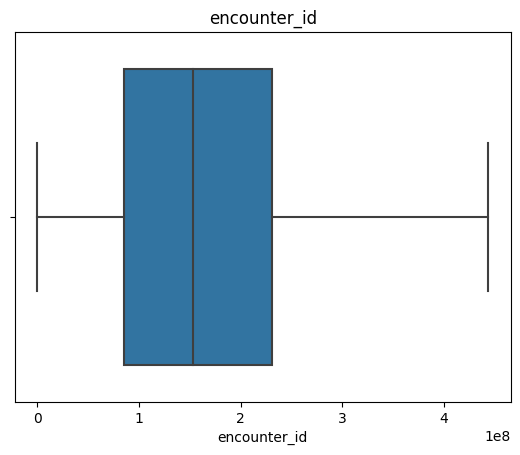

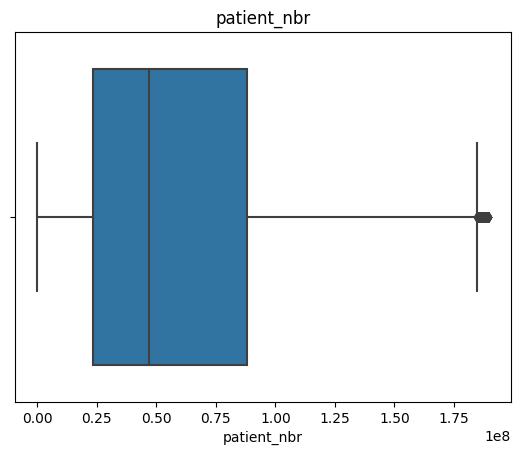

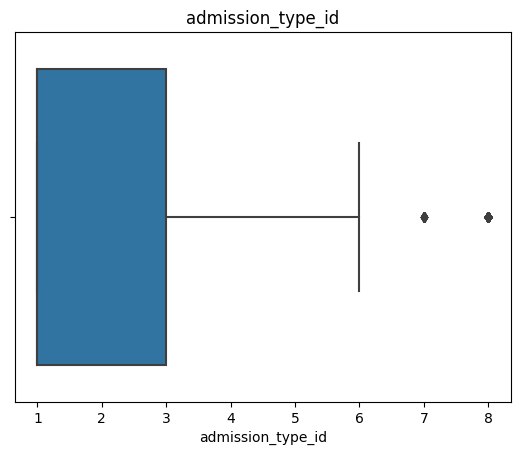

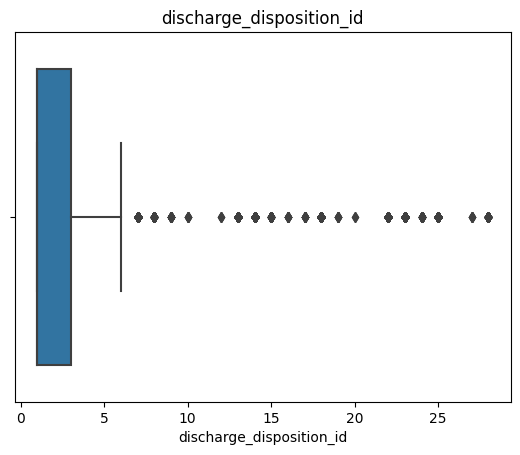

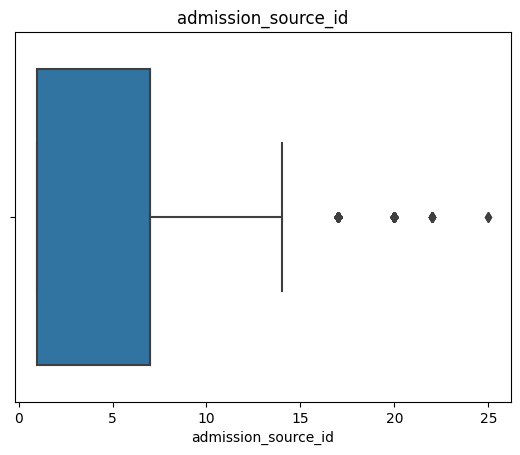

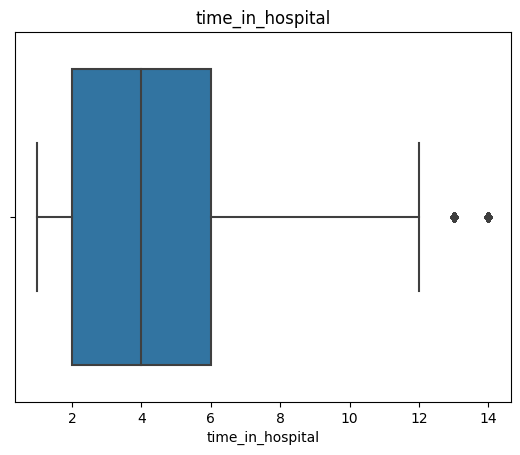

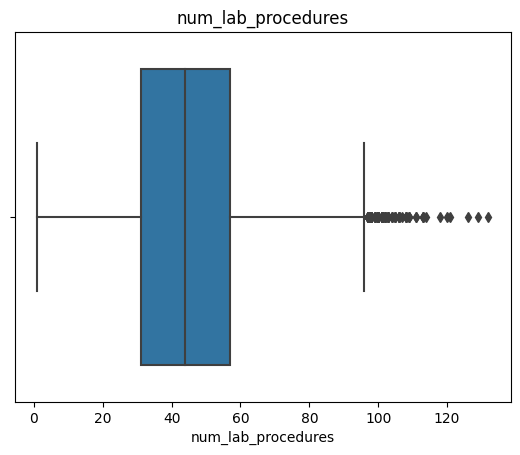

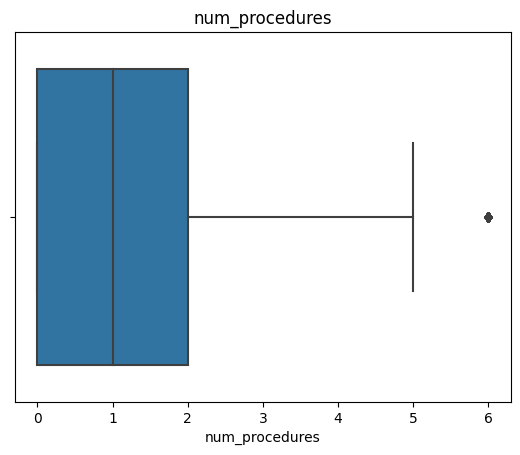

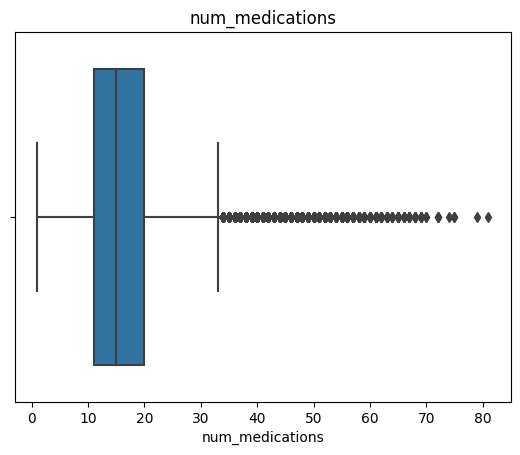

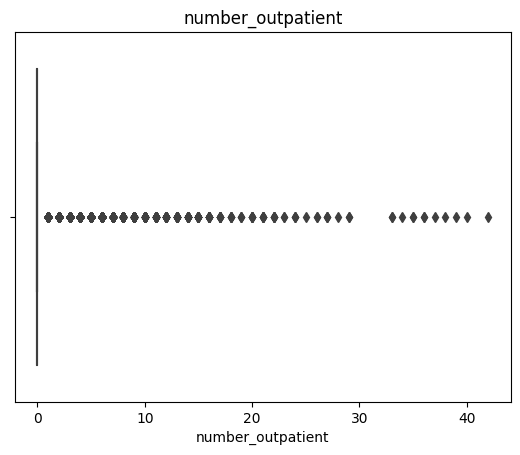

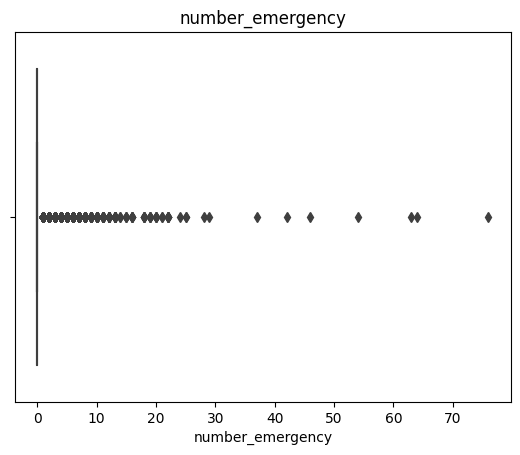

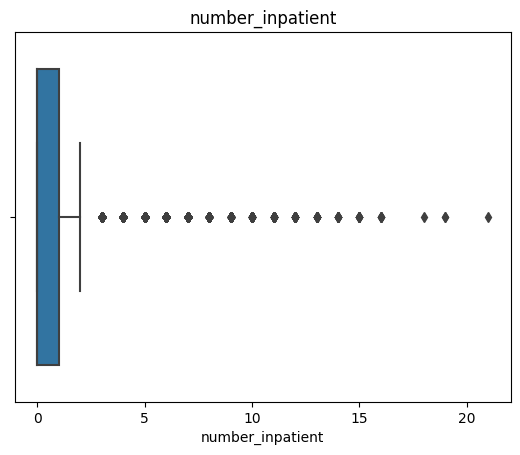

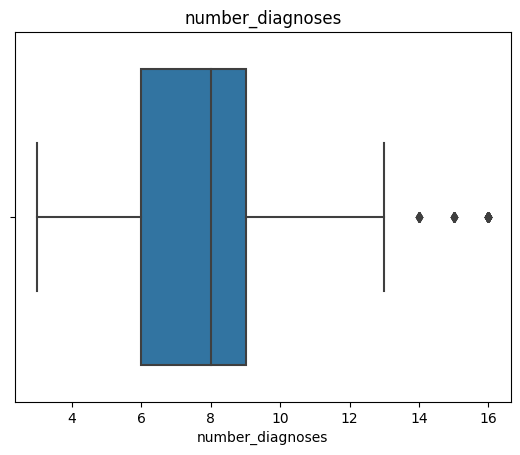

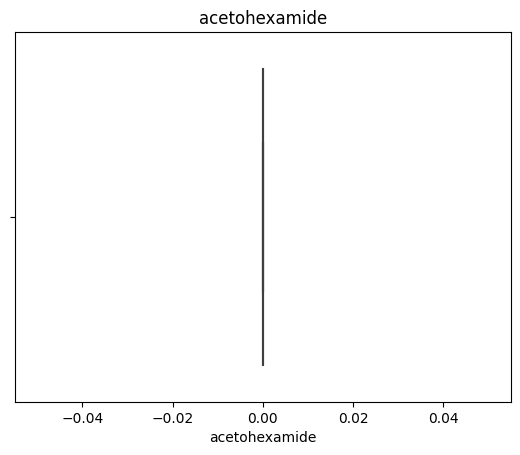

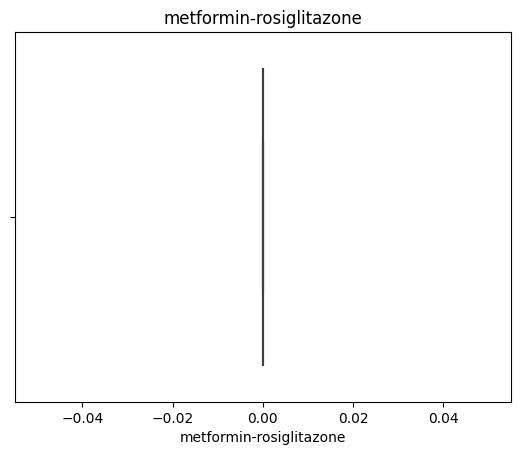

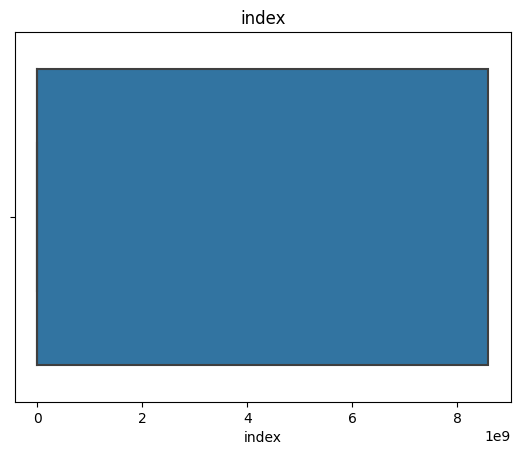

(96446, 46)
CPU times: user 5.5 s, sys: 2.43 s, total: 7.92 s
Wall time: 24.4 s


In [ ]:
%%time
pandas_df = data.toPandas()
# Create subplots for each numeric column
for col in numeric_columns:
    sns.boxplot(x=pandas_df[col].dropna())
    plt.title(col)
    plt.show()
print((data.count(), len(data.columns)))

In [ ]:
# %%time
# # Iterate over the numeric columns
# for column in numeric_columns:
#     # Compute Tukey's fences for the column
#     q1, q3 = data.approxQuantile(column, [0.25, 0.75], 0.01)
#     iqr = q3 - q1
#     lower_fence = q1 - 1.5 * iqr
#     upper_fence = q3 + 1.5 * iqr

#     # Filter out any values outside the fences
#     data = data.filter((data[column] >= lower_fence) & (data[column] <= upper_fence))

**Creating new features and logically encoding the original features**

In [ ]:
## Feature 1: Service Utilization
from pyspark.sql.functions import *
data=data.withColumn('service_utilization', col('number_outpatient') + col('number_emergency') + col('number_inpatient'))

In [ ]:
keys = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']
data = data.withColumn('numchange', lit(0))
for i in keys:
    colname = i + 'temp'
    data = data.withColumn(colname, when((col(i) == 'No') | (col(i) == 'Steady'), 0).otherwise(1))
    data = data.withColumn('numchange', col('numchange') + col(colname))
    data = data.drop(colname)

In [ ]:
# create a duplicate of the diagnosis column
data = data.withColumn("level1_diag1", col("diag_1"))

# disease codes starting with V or E are in “other” category; so recode them to 0
data = data.withColumn("level1_diag1", when(col("diag_1").contains("V") | col("diag_1").contains("E"), 0).otherwise(col("level1_diag1")))

# also replace the unknown values with -1
data=data.withColumn("level1_diag1", when(col("level1_diag1") == "?", -1).otherwise(col("level1_diag1")))

# recode disease codes between certain ranges to certain categories
data=data.withColumn("level1_diag1", when((col("level1_diag1") >= 390) & (col("level1_diag1") < 460) | (floor(col("level1_diag1")) == 785), 1)
                                 .when((col("level1_diag1") >= 460) & (col("level1_diag1") < 520) | (floor(col("level1_diag1")) == 786), 2)
                                 .when((col("level1_diag1") >= 520) & (col("level1_diag1") < 580) | (floor(col("level1_diag1")) == 787), 3)
                                 .when(floor(col("level1_diag1")) == 250, 4)
                                 .when((col("level1_diag1") >= 800) & (col("level1_diag1") < 1000), 5)
                                 .when((col("level1_diag1") >= 710) & (col("level1_diag1") < 740), 6)
                                 .when((col("level1_diag1") >= 580) & (col("level1_diag1") < 630) | (floor(col("level1_diag1")) == 788), 7)
                                 .when((col("level1_diag1") >= 140) & (col("level1_diag1") < 240), 8)
                                 .otherwise(0))

# convert this variable to float type to enable computations later
data=data.withColumn("level1_diag1", col("level1_diag1").cast("float"))

In [ ]:
from pyspark.sql.functions import when, col
data = data.withColumn("admission_type_id", when(col("admission_type_id") == 2, 1)
                      .when(col("admission_type_id") == 7, 1)
                      .when(col("admission_type_id") == 6, 5)
                      .when(col("admission_type_id") == 8, 5)
                      .otherwise(col("admission_type_id")))


In [ ]:
from pyspark.sql.functions import when
data=data.withColumn('change', when(data['change'] == 'Ch', 1).otherwise(0))
data=data.withColumn('gender', when(data['gender'] == 'Male', 1).otherwise(0))
data=data.withColumn('diabetesMed', when(data['diabetesMed'] == 'Yes', 1).otherwise(0))
for col in keys:
    data=data.withColumn(col, when((data[col] == 'No') | (data[col] == 'Steady') | (data[col] == 'Up') | (data[col] == 'Down'), 1).otherwise(0))

In [ ]:
from pyspark.sql.functions import when
data=data.withColumn('A1Cresult', when(data['A1Cresult'] == '>7', 1)
                                 .when(data['A1Cresult'] == '>8', 1)
                                 .when(data['A1Cresult'] == 'Norm', 0)
                                 .when(data['A1Cresult'] == 'None', -99))
data=data.withColumn('max_glu_serum', when(data['max_glu_serum'] == '>200', 1)
                                    .when(data['max_glu_serum'] == '>300', 1)
                                    .when(data['max_glu_serum'] == 'Norm', 0)
                                    .when(data['max_glu_serum'] == 'None', -99))

In [ ]:
data=data.withColumn('readmitted', when(data['readmitted'] == '>30', 0).when(data['readmitted'] == '<30', 1).when(data['readmitted'] == 'NO', 0).otherwise(None))

In [ ]:
data=data.withColumn('age', when(data['age'] == '[0-10)', 5).when(data['age'] == '[10-20)', 15).when(data['age'] == '[20-30)', 25).when(data['age'] == '[30-40)', 35).when(data['age'] == '[40-50)', 45).when(data['age'] == '[50-60)', 55).when(data['age'] == '[60-70)', 65).when(data['age'] == '[70-80)', 75).when(data['age'] == '[80-90)', 85).when(data['age'] == '[90-100)', 95).otherwise(0))

In [ ]:
data=data.withColumn('race', when(data['race'] == 'Caucasian', 1)
                                 .when(data['race'] == 'Other', 0)
                                 .when(data['race'] == 'AfricanAmerican', 2)
                                 .when(data['race'] == 'Hispanic', 3)
                                 .when(data['race'] == 'Asian', 4))

In [ ]:
data.show(2)

+------------+-----------+----+------+---+-----------------+------------------------+-------------------+----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+-----+-------------------+---------+------------+
|encounter_id|patient_nbr|race|gender|age|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_serum|A1Cresult|metformin|repaglinide|nateglinide|chlorpropamide|gli

In [ ]:
%%time
# convert categorical with categories less than 6 into one hot encode columns in pyspark
# loop through each categorical column and print its distinct values
for col in categorical_columns:
    print("Distinct values for column '{}':".format(col))
    data.select(col).distinct().show()

Distinct values for column 'race':
+----+
|race|
+----+
|   1|
|   3|
|   4|
|   2|
|   0|
+----+

Distinct values for column 'gender':
+------+
|gender|
+------+
|     1|
|     0|
+------+

Distinct values for column 'age':
+---+
|age|
+---+
| 85|
| 65|
|  5|
| 15|
| 35|
| 55|
| 45|
| 25|
| 95|
| 75|
+---+

Distinct values for column 'diag_1':
+------+
|diag_1|
+------+
|   296|
|   691|
|   451|
|   853|
|   800|
|   944|
|   870|
|   447|
|   591|
|     7|
|250.01|
|   574|
|   475|
|   718|
|   307|
|   577|
|   581|
|   205|
|   747|
|   334|
+------+
only showing top 20 rows

Distinct values for column 'diag_2':
+------+
|diag_2|
+------+
|   296|
|   691|
|   451|
|   V72|
|   800|
|   944|
|   919|
|   870|
|250.01|
|   447|
|   591|
|   574|
|   718|
|   475|
|   307|
|   577|
|   581|
|   205|
|  E858|
|   747|
+------+
only showing top 20 rows

Distinct values for column 'diag_3':
+------+
|diag_3|
+------+
|   296|
|   451|
|  E876|
|   V72|
|   944|
|   853|
|   919|
|   8

In [ ]:
data.printSchema()

root
 |-- encounter_id: integer (nullable = true)
 |-- patient_nbr: integer (nullable = true)
 |-- race: integer (nullable = true)
 |-- gender: integer (nullable = false)
 |-- age: integer (nullable = false)
 |-- admission_type_id: integer (nullable = true)
 |-- discharge_disposition_id: integer (nullable = true)
 |-- admission_source_id: integer (nullable = true)
 |-- time_in_hospital: integer (nullable = true)
 |-- num_lab_procedures: integer (nullable = true)
 |-- num_procedures: integer (nullable = true)
 |-- num_medications: integer (nullable = true)
 |-- number_outpatient: double (nullable = true)
 |-- number_emergency: double (nullable = true)
 |-- number_inpatient: double (nullable = true)
 |-- diag_1: string (nullable = true)
 |-- diag_2: string (nullable = true)
 |-- diag_3: string (nullable = true)
 |-- number_diagnoses: integer (nullable = true)
 |-- max_glu_serum: integer (nullable = true)
 |-- A1Cresult: integer (nullable = true)
 |-- metformin: integer (nullable = false)

### Converting categorical variables to numerical using StringIndexer

In [ ]:
cat_cols = ['diag_1', 'diag_2', 'diag_3']

In [ ]:
# Create a StringIndexer object for each categorical variable column
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index").fit(data) for col in cat_cols]

# Transform the data using the StringIndexer objects
indexed_data = data
for indexer in indexers:
    indexed_data = indexer.transform(indexed_data)


# Show the results
indexed_data.show()


+------------+-----------+----+------+---+-----------------+------------------------+-------------------+----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+-----+-------------------+---------+------------+------------+------------+------------+
|encounter_id|patient_nbr|race|gender|age|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_serum|A1Cresult|metformin|rep

### For the string indexer generated in previous step, encoding them using OneHotEncoder

In [ ]:
# Create a list of OneHotEncoder objects for each indexed categorical variable column
encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_onehot") for col in cat_cols]

# Fit and transform the data using the OneHotEncoder objects
encoded_data = indexed_data
for encoder in encoders:
    encoded_data = encoder.fit(encoded_data).transform(encoded_data)

# Show the results
encoded_data.show(10)



+------------+-----------+----+------+---+-----------------+------------------------+-------------------+----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+-----+-------------------+---------+------------+------------+------------+------------+-----------------+-----------------+-----------------+
|encounter_id|patient_nbr|race|gender|age|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|

In [ ]:
encoded_data.printSchema()

root
 |-- encounter_id: integer (nullable = true)
 |-- patient_nbr: integer (nullable = true)
 |-- race: integer (nullable = true)
 |-- gender: integer (nullable = false)
 |-- age: integer (nullable = false)
 |-- admission_type_id: integer (nullable = true)
 |-- discharge_disposition_id: integer (nullable = true)
 |-- admission_source_id: integer (nullable = true)
 |-- time_in_hospital: integer (nullable = true)
 |-- num_lab_procedures: integer (nullable = true)
 |-- num_procedures: integer (nullable = true)
 |-- num_medications: integer (nullable = true)
 |-- number_outpatient: double (nullable = true)
 |-- number_emergency: double (nullable = true)
 |-- number_inpatient: double (nullable = true)
 |-- diag_1: string (nullable = true)
 |-- diag_2: string (nullable = true)
 |-- diag_3: string (nullable = true)
 |-- number_diagnoses: integer (nullable = true)
 |-- max_glu_serum: integer (nullable = true)
 |-- A1Cresult: integer (nullable = true)
 |-- metformin: integer (nullable = false)

In [ ]:
col_to_rem = ['index', 'encounter_id', 'patient_nbr']
encoded_data = encoded_data.drop(*col_to_rem)
encoded_data.printSchema()

root
 |-- race: integer (nullable = true)
 |-- gender: integer (nullable = false)
 |-- age: integer (nullable = false)
 |-- admission_type_id: integer (nullable = true)
 |-- discharge_disposition_id: integer (nullable = true)
 |-- admission_source_id: integer (nullable = true)
 |-- time_in_hospital: integer (nullable = true)
 |-- num_lab_procedures: integer (nullable = true)
 |-- num_procedures: integer (nullable = true)
 |-- num_medications: integer (nullable = true)
 |-- number_outpatient: double (nullable = true)
 |-- number_emergency: double (nullable = true)
 |-- number_inpatient: double (nullable = true)
 |-- diag_1: string (nullable = true)
 |-- diag_2: string (nullable = true)
 |-- diag_3: string (nullable = true)
 |-- number_diagnoses: integer (nullable = true)
 |-- max_glu_serum: integer (nullable = true)
 |-- A1Cresult: integer (nullable = true)
 |-- metformin: integer (nullable = false)
 |-- repaglinide: integer (nullable = false)
 |-- nateglinide: integer (nullable = false

In [ ]:
cols = encoded_data.columns
cols

['race',
 'gender',
 'age',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'diag_1',
 'diag_2',
 'diag_3',
 'number_diagnoses',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed',
 'readmitted',
 'service_utilization',
 'numchange',
 'level1_diag1',
 'diag_1_index',
 'diag_2_index',
 'diag_3_index',
 'diag_1_onehot',
 'diag_2_onehot',
 'diag_3_onehot']

In [ ]:
for item in cat_cols:
    cols.remove(item)

cols.remove('readmitted')

In [ ]:
cols

['race',
 'gender',
 'age',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed',
 'service_utilization',
 'numchange',
 'level1_diag1',
 'diag_1_index',
 'diag_2_index',
 'diag_3_index',
 'diag_1_onehot',
 'diag_2_onehot',
 'diag_3_onehot']

### Assemble feature vectors to build the ML model

In [ ]:
# Create a VectorAssembler object to assemble the features into a single vector column
assembler = VectorAssembler(inputCols=cols, outputCol="features")

# Use the assembler to transform the encoded data
assembled_data = assembler.transform(encoded_data)

# Show the first 20 rows of the assembled data
assembled_data.show(20)

+----+------+---+-----------------+------------------------+-------------------+----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+-------------------+---------+------------+------------+------------+------------+-----------------+-----------------+-----------------+--------------------+
|race|gender|age|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_serum|A1Cr

In [ ]:
# Select only the 'default' and 'features' columns for the final model fit
final_data = assembled_data.select('readmitted', 'features')
final_data.show(20)

+----------+--------------------+
|readmitted|            features|
+----------+--------------------+
|         0|(2277,[0,2,3,4,5,...|
|         0|(2277,[0,2,3,4,5,...|
|         0|(2277,[0,1,2,3,4,...|
|         0|(2277,[0,1,2,3,4,...|
|         0|(2277,[0,1,2,3,4,...|
|         0|(2277,[0,1,2,3,4,...|
|         0|(2277,[0,1,2,3,4,...|
|         0|(2277,[0,2,3,4,5,...|
|         0|(2277,[0,2,3,4,5,...|
|         0|(2277,[0,2,3,4,5,...|
|         1|(2277,[0,1,2,3,4,...|
|         1|(2277,[0,2,3,4,5,...|
|         0|(2277,[0,1,2,3,4,...|
|         0|(2277,[0,2,3,4,5,...|
|         0|(2277,[0,1,2,3,4,...|
|         1|(2277,[0,1,2,3,4,...|
|         0|(2277,[0,2,3,4,5,...|
|         0|(2277,[0,1,2,3,4,...|
|         0|(2277,[0,2,3,4,5,...|
|         0|(2277,[0,2,3,4,5,...|
+----------+--------------------+
only showing top 20 rows



### Train-test split

In [ ]:
train_data, test_data = final_data.randomSplit([0.7, 0.3], seed=42)

### Building a Logistic Regression Model

In [ ]:
# Step 11: Train a logistic regression model
from pyspark.ml.classification import LogisticRegression

# Create a logistic regression object with specified settings
lr = LogisticRegression(labelCol = 'readmitted', featuresCol = 'features', maxIter=10, regParam=0.01)

# Fit the model to the training data
lr_model = lr.fit(train_data)

predictions = lr_model.transform(test_data)

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Create a binary classification evaluator
evaluator = BinaryClassificationEvaluator(labelCol='readmitted')

# Compute the ROC AUC on the test data
roc_auc = evaluator.evaluate(predictions)

# Print the ROC AUC score
print(f'ROC AUC: {roc_auc}')


ROC AUC: 0.6304861771418334


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluate the model using accuracy
evaluator = MulticlassClassificationEvaluator(labelCol='readmitted', predictionCol = "prediction", metricName='accuracy')
accuracy = evaluator.evaluate(predictions)

print(f"Accuracy: {accuracy}")


Accuracy: 0.8819362455726092


**Hyperparameters tuning**

---



In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator 

In [ ]:
# Define parameter grid for model tuning
paramGrid = (ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build())

# Define cross-validator
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=MulticlassClassificationEvaluator(labelCol='readmitted', predictionCol = "prediction", metricName='accuracy'), numFolds=5)

# Run cross validations.
cvModel = cv.fit(train_data)

# Evaluate the performance of the tuned model on the test set
predictions = cvModel.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol='readmitted', predictionCol = "prediction", metricName='accuracy')
accuracy = evaluator.evaluate(predictions)

print(f"Accuracy on test set (tuned model): {accuracy:.4f}")


Accuracy on test set (tuned model): 0.8829


In [ ]:
!pip install streamlit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 18.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 66.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.5 MB/s eta 0:00:00
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19579 sha256=b27a11cfa5cb07589e8b8582c4336c2fdce4160ef47a3385f3a2be3511681abb
  Stored in directory: /root/.cache/pip/wheels/2d/f0/a8/1094fca7a7e5d0d12ff56e0c64675d72aa5cc81a5fc200e849
Successfully built validators


In [ ]:
import streamlit as st

In [ ]:
st.sidebar.title('BDI Project')

  command:

    streamlit run /usr/local/lib/python3.9/dist-packages/ipykernel_launcher.py [ARGUMENTS]
2023-04-27 07:12:20.420 
  command:

    streamlit run /usr/local/lib/python3.9/dist-packages/ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator(_root_container=1, _parent=DeltaGenerator())